<a href="https://colab.research.google.com/github/MokkeMeguru/glow-realnvp-tutorial/blob/master/examples/jupyter_notebooks/%5Bcopy_from_official%5Dffjord_moons_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First install packages used in this demo.

In [0]:
!pip install tfp-nightly tf-nightly "dm-sonnet>=2.0.0b0" --pre

     |████████████████████████████████| 3.2MB 4.7MB/s 
     |████████████████████████████████| 441.8MB 38kB/s 
     |████████████████████████████████| 911kB 50.9MB/s 
     |████████████████████████████████| 3.9MB 50.3MB/s 
     |████████████████████████████████| 2.9MB 55.4MB/s 
     |████████████████████████████████| 460kB 70.7MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
ERROR: graph-nets 1.0.5 has requirement dm-sonnet<2, but you'll have dm-sonnet 2.0.0b0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
ERROR: tb-nightly 2.2.0a20191218 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existin

In [0]:
#@title Imports (tf, tfp with adjoint trick, etc)
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

def make_grid(xmin, xmax, ymin, ymax, gridlines, pts):
  xpts = np.linspace(xmin, xmax, pts)
  ypts = np.linspace(ymin, ymax, pts)
  xgrid = np.linspace(xmin, xmax, gridlines)
  ygrid = np.linspace(ymin, ymax, gridlines)
  xlines = np.stack([a.ravel() for a in np.meshgrid(xpts, ygrid)])
  ylines = np.stack([a.ravel() for a in np.meshgrid(xgrid, ypts)])
  return np.concatenate([xlines, ylines], 1).T

grid = make_grid(-3, 3, -3, 3, 4, 100)

In [0]:
#@title Helper functions for visualization
def plot_density(data, axis):
  x, y = np.squeeze(np.split(data, 2, axis=1))
  levels = np.linspace(0.0, 0.75, 10)
  kwargs = {'levels': levels}
  return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis, **kwargs)


def plot_points(data, axis, s=10, color='b', label=''):
  x, y = np.squeeze(np.split(data, 2, axis=1))
  axis.scatter(x, y, c=color, s=s, label=label)


def plot_panel(
    grid, samples, transformed_grid, transformed_samples,
    dataset, axarray, limits=True):
  if len(axarray) != 4:
    raise ValueError('Expected 4 axes for the panel')
  ax1, ax2, ax3, ax4 = axarray
  plot_points(data=grid, axis=ax1, s=20, color='black', label='grid')
  plot_points(samples, ax1, s=30, color='blue', label='samples')
  plot_points(transformed_grid, ax2, s=20, color='black', label='ode(grid)')
  plot_points(transformed_samples, ax2, s=30, color='blue', label='ode(samples)')
  ax3 = plot_density(transformed_samples, ax3)
  ax4 = plot_density(dataset, ax4)
  if limits:
    set_limits([ax1], -3.0, 3.0, -3.0, 3.0)
    set_limits([ax2], -2.0, 3.0, -2.0, 3.0)
    set_limits([ax3, ax4], -1.5, 2.5, -0.75, 1.25)


def set_limits(axes, min_x, max_x, min_y, max_y):
  if isinstance(axes, list):
    for axis in axes:
      set_limits(axis, min_x, max_x, min_y, max_y)
  else:
    axes.set_xlim(min_x, max_x)
    axes.set_ylim(min_y, max_y)

# FFJORD bijector
In this colab we demonstrate FFJORD bijector, originally proposed in the paper by Grathwohl, Will, et al. [arxiv link](https://arxiv.org/pdf/1810.01367.pdf).

In the nutshell the idea behind such approach is to establish a correspondence between a known **base distribution** and the **data distribution**.

To establish this connection, we need to

  1. Define a bijective map $\mathcal{T}_{\theta}:\mathbf{x} \rightarrow \mathbf{y}$, $\mathcal{T}_{\theta}^{1}:\mathbf{y} \rightarrow \mathbf{x}$ between the space $\mathcal{Y}$ on which **base distribution** is defined and space $\mathcal{X}$ of the data domain.
  2. Efficiently keep track of the deformations we perform to transfer the notion of probability onto $\mathcal{X}$.

The second condition is formalized in the following expression for probability
distribution defined on $\mathcal{X}$:

$$
\log p_{\mathbf{x}}(\mathbf{x})=\log p_{\mathbf{y}}(\mathbf{y})-\log \operatorname{det}\left|\frac{\partial \mathcal{T}_{\theta}(\mathbf{y})}{\partial \mathbf{y}}\right|
$$

FFJORD bijector accomplishes this by defining a transformation 
$$
\mathcal{T_{\theta}}: \mathbf{x} = \mathbf{z}(t_{0}) \rightarrow \mathbf{y} = \mathbf{z}(t_{1}) \quad : \quad \frac{d \mathbf{z}}{dt} = \mathbf{f}(t, \mathbf{z}, \theta)
$$

This transformation is invertible, as long as function $\mathbf{f}$ describing the evolution of the state $\mathbf{z}$ is well behaved and the `log_det_jacobian` can be calculated by integrating the following expression.

$$
\log \operatorname{det}\left|\frac{\partial \mathcal{T}_{\theta}(\mathbf{y})}{\partial \mathbf{y}}\right| = 
-\int_{t_{0}}^{t_{1}} \operatorname{Tr}\left(\frac{\partial \mathbf{f}(t, \mathbf{z}, \theta)}{\partial \mathbf{z}(t)}\right) d t
$$

In this demo we will train a FFJORD bijector to warp a gaussian distribution onto the distribution defined by `moons` dataset. This will be done in 3 steps:
  * Define **base distribution**
  * Define FFJORD bijector
  * Minimize exact log-likelihood of the dataset

First, we load the data

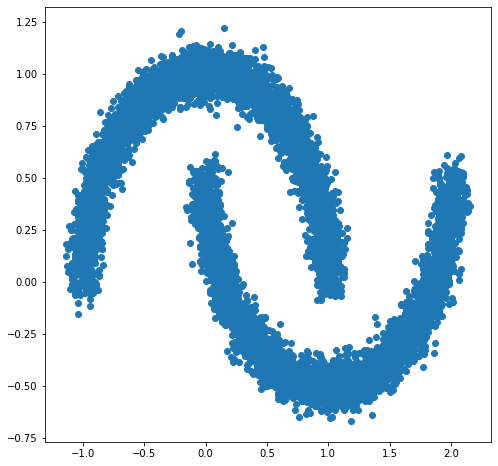

In [0]:
#@title Dataset
DATASET_SIZE = 1024 * 8  #@param
BATCH_SIZE = 256  #@param
SAMPLE_SIZE = DATASET_SIZE

moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]

moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE)
moons_ds = moons_ds.batch(BATCH_SIZE)

plt.figure(figsize=[8, 8])
plt.scatter(moons[:, 0], moons[:, 1])
plt.show()

Next, we instantiate a base distribution

In [0]:
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([0.8, 0.8]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)

We use a multi-layer perceptron to model `state_derivative_fn`.

While not necessary for this dataset, it is often benefitial to make `state_derivative_fn` dependent on time. Here we achieve this by concatenating `t` to inputs of our network.

In [0]:
class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output))
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    return self._model(inputs)

In [0]:
#@title Model and training parameters
LR = 1e-2  #@param
NUM_EPOCHS = 80  #@param
STACKED_FFJORDS = 4  #@param
NUM_HIDDEN = 8  #@param
NUM_LAYERS = 3  #@param
NUM_OUTPUT = 2

Now we construct a stack of FFJORD bijectors. Each bijector is provided with `ode_solve_fn` and `trace_augmentation_fn` and it's own `state_derivative_fn` model, so that they represent a sequence of different transformations.

In [0]:
#@title Building bijector
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact

bijectors = []
for _ in range(STACKED_FFJORDS):
  mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
  next_ffjord = tfb.FFJORD(
      state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
      trace_augmentation_fn=trace_augmentation_fn)
  bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

Now we can use `TransformedDistribution` which is the result of warping `base_distribution` with `stacked_ffjord` bijector.

In [0]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)

Now we define our training procedure. We simply minimize negative log-likelihood of the data.

In [0]:
#@titel Training
@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply(gradients, variables)
  return loss

In [0]:
#@titel Samples
@tf.function
def get_samples():
  base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
  transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
  return base_distribution_samples, transformed_samples


@tf.function
def get_transformed_grid():
  transformed_grid = stacked_ffjord.forward(grid)
  return transformed_grid

Plot samples from base and transformed distributions.

In [0]:
evaluation_samples = []
base_samples, transformed_samples = get_samples()
transformed_grid = get_transformed_grid()
evaluation_samples.append((base_samples, transformed_samples, transformed_grid))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


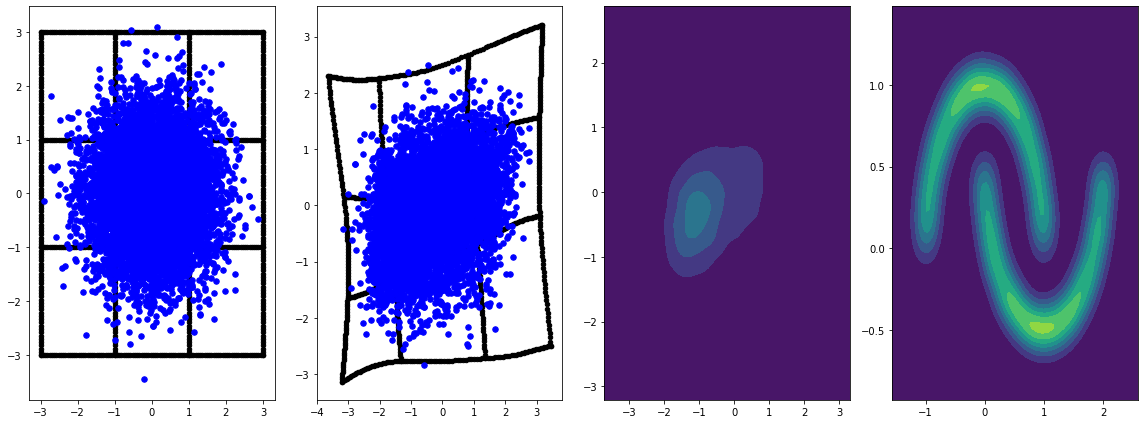

In [0]:
panel_id = 0
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(
  1, 4, figsize=(16, 6))
plot_panel(
    grid, panel_data[0], panel_data[2], panel_data[1], moons, axarray, False)
plt.tight_layout()

In [0]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
  base_samples, transformed_samples = get_samples()
  transformed_grid = get_transformed_grid()
  evaluation_samples.append(
      (base_samples, transformed_samples, transformed_grid))
  for batch in moons_ds:
    _ = train_step(optimizer, batch)

100%|██████████| 40/40 [16:15<00:00, 24.88s/it]


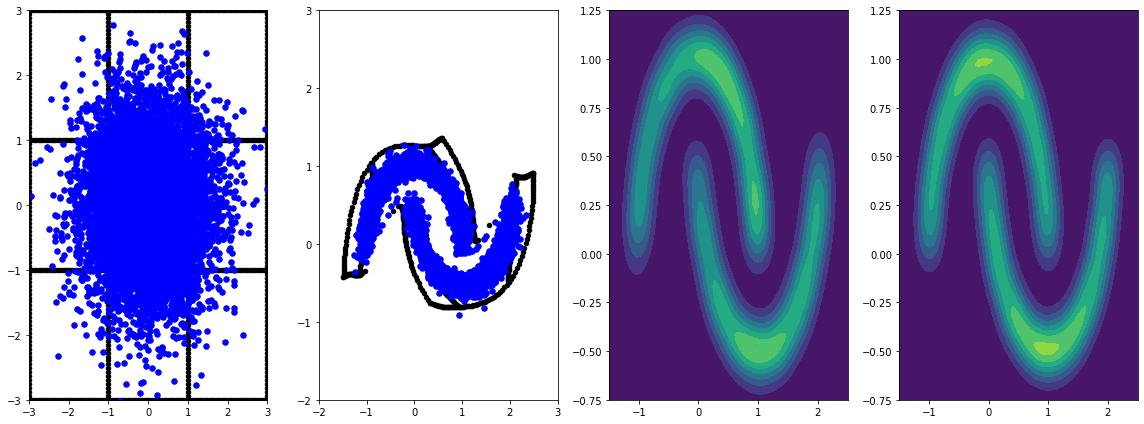

In [0]:
panel_id = -1
panel_data = evaluation_samples[panel_id]
fig, axarray = plt.subplots(
  1, 4, figsize=(16, 6))
plot_panel(grid, panel_data[0], panel_data[2], panel_data[1], moons, axarray)
plt.tight_layout()

Training it for longer with learning rate results in further improvements.

Not convered in this example, FFJORD bijector supports hutchinson's stochastic trace estimation. The particular estimator can be provided via `trace_augmentation_fn`. Similarly alternative integrators can be used by defining custom `ode_solve_fn`. 

In [0]:
#@title Dataset
TEST_DATASET_SIZE = 1024 * 8  #@param
BATCH_SIZE = 256  #@param
SAMPLE_SIZE = TEST_DATASET_SIZE

moons = skd.make_moons(n_samples=DATASET_SIZE, noise=.06)[0]

moons_ds = tf.data.Dataset.from_tensor_slices(moons.astype(np.float32))
moons_ds = moons_ds.prefetch(tf.data.experimental.AUTOTUNE)
moons_ds = moons_ds.cache()
moons_ds = moons_ds.shuffle(DATASET_SIZE)
moons_ds = moons_ds.batch(BATCH_SIZE)

In [0]:
#@titel Training
@tf.function
def eval_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  # variables = tape.watched_variables()
  # gradients = tape.gradient(loss, variables)
  # optimizer.apply(gradients, variables)
  return loss

In [0]:
losses = []
for batch in moons_ds:
    losses.append(eval_step(optimizer, batch))

print('eval Loss [raw]         : {}'.format(tf.reduce_mean(losses)))
print('eval Loss [bits/dim]: {}'.format(tf.reduce_mean(losses) / (np.log(2.) * 2)))

eval Loss [raw]         : 0.527558445930481
eval Loss [bits/dim]: 0.3805529773235321
